In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('text', usetex = True)
import h5py

## Load the qnm package

We'll load it from this repo, so you don't even have to do a system install to use this notebook

In [3]:
import sys
sys.path.insert(0,"..")

In [4]:
from packaging import version

In [5]:
import qnm
print(qnm.__path__)
print(qnm.__version__)
if version.parse(qnm.__version__) < version.parse("0.4.0"):
    raise ImportError("Need at least version 0.4.0 of package qnm; got {}".format(qnm.__version__))

['../qnm']
0.4.0


In [6]:
qnm.download_data()

Destination path /Users/leo/.qnm/data-0.4.0.tar.bz2 already exists, use overwrite=True to force an overwrite.


## Getting Cook's data from Zenodo

See [Greg's Zenodo record here](https://zenodo.org/record/2650358/).

In [7]:
from urllib.request import urlretrieve
from pathlib import Path
from tqdm import tqdm

In [8]:
cook_n_range = np.arange(0,8)

def cook_filename(n):
    if n not in cook_n_range:
        raise ValueError('n={} is not in cook_n_range'.format(n))
    return 'KerrQNM_{:02d}.h5'.format(n)

def cook_url(n):
    return 'https://zenodo.org/record/2650358/files/' + cook_filename(n) + '?download=1'

In [9]:
############################################################
# This is taken verbatim from the tqdm examples, see
# https://pypi.org/project/tqdm/#hooks-and-callbacks

class _TqdmUpTo(tqdm):
    """Provides `update_to(n)` which uses `tqdm.update(delta_n)`."""
    def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize

In [10]:
cook = {}

def mode_dataset(l, m, n):
    filename = cook_filename(n)
    p = Path(filename)
    if not p.exists():
        print('File is not on disk, fetching...')
        with _TqdmUpTo(unit='B', unit_scale=True, miniters=1,
                       desc=filename) as t:
            urlretrieve(cook_url(n), filename=filename, reporthook=t.update_to)

    f = h5py.File(filename)
    dataname = 'n{2:02d}/m{1:+03d}/{{{0:},{1:},{2:}}}'.format(l,m,n)
    return f[dataname]

def load_mode(l, m, n):
    global cook
    data  = mode_dataset(l,m,n)
    obj = {}
    obj['a']     = data[:,0]
    obj['omega'] = data[:,1] + 1.j*data[:,2]
    obj['A']     = data[:,3] + 1.j*data[:,4]
    obj['C']     = data[:,5::2] + 1.j*data[:,6::2]
    
    cook[(l,m,n)] = obj
    
    return obj

In [11]:
ls = np.arange(2,5)
ns = cook_n_range
for l in ls:
    for m in np.arange(-l, l+1):
        for n in ns:
            load_mode(l,m,n)

## Compare!

We will use the Leaver solver in `qnm` to evaluate the QNMs at the same values of $a$ as provided by Cook. That way, we can just subtract.

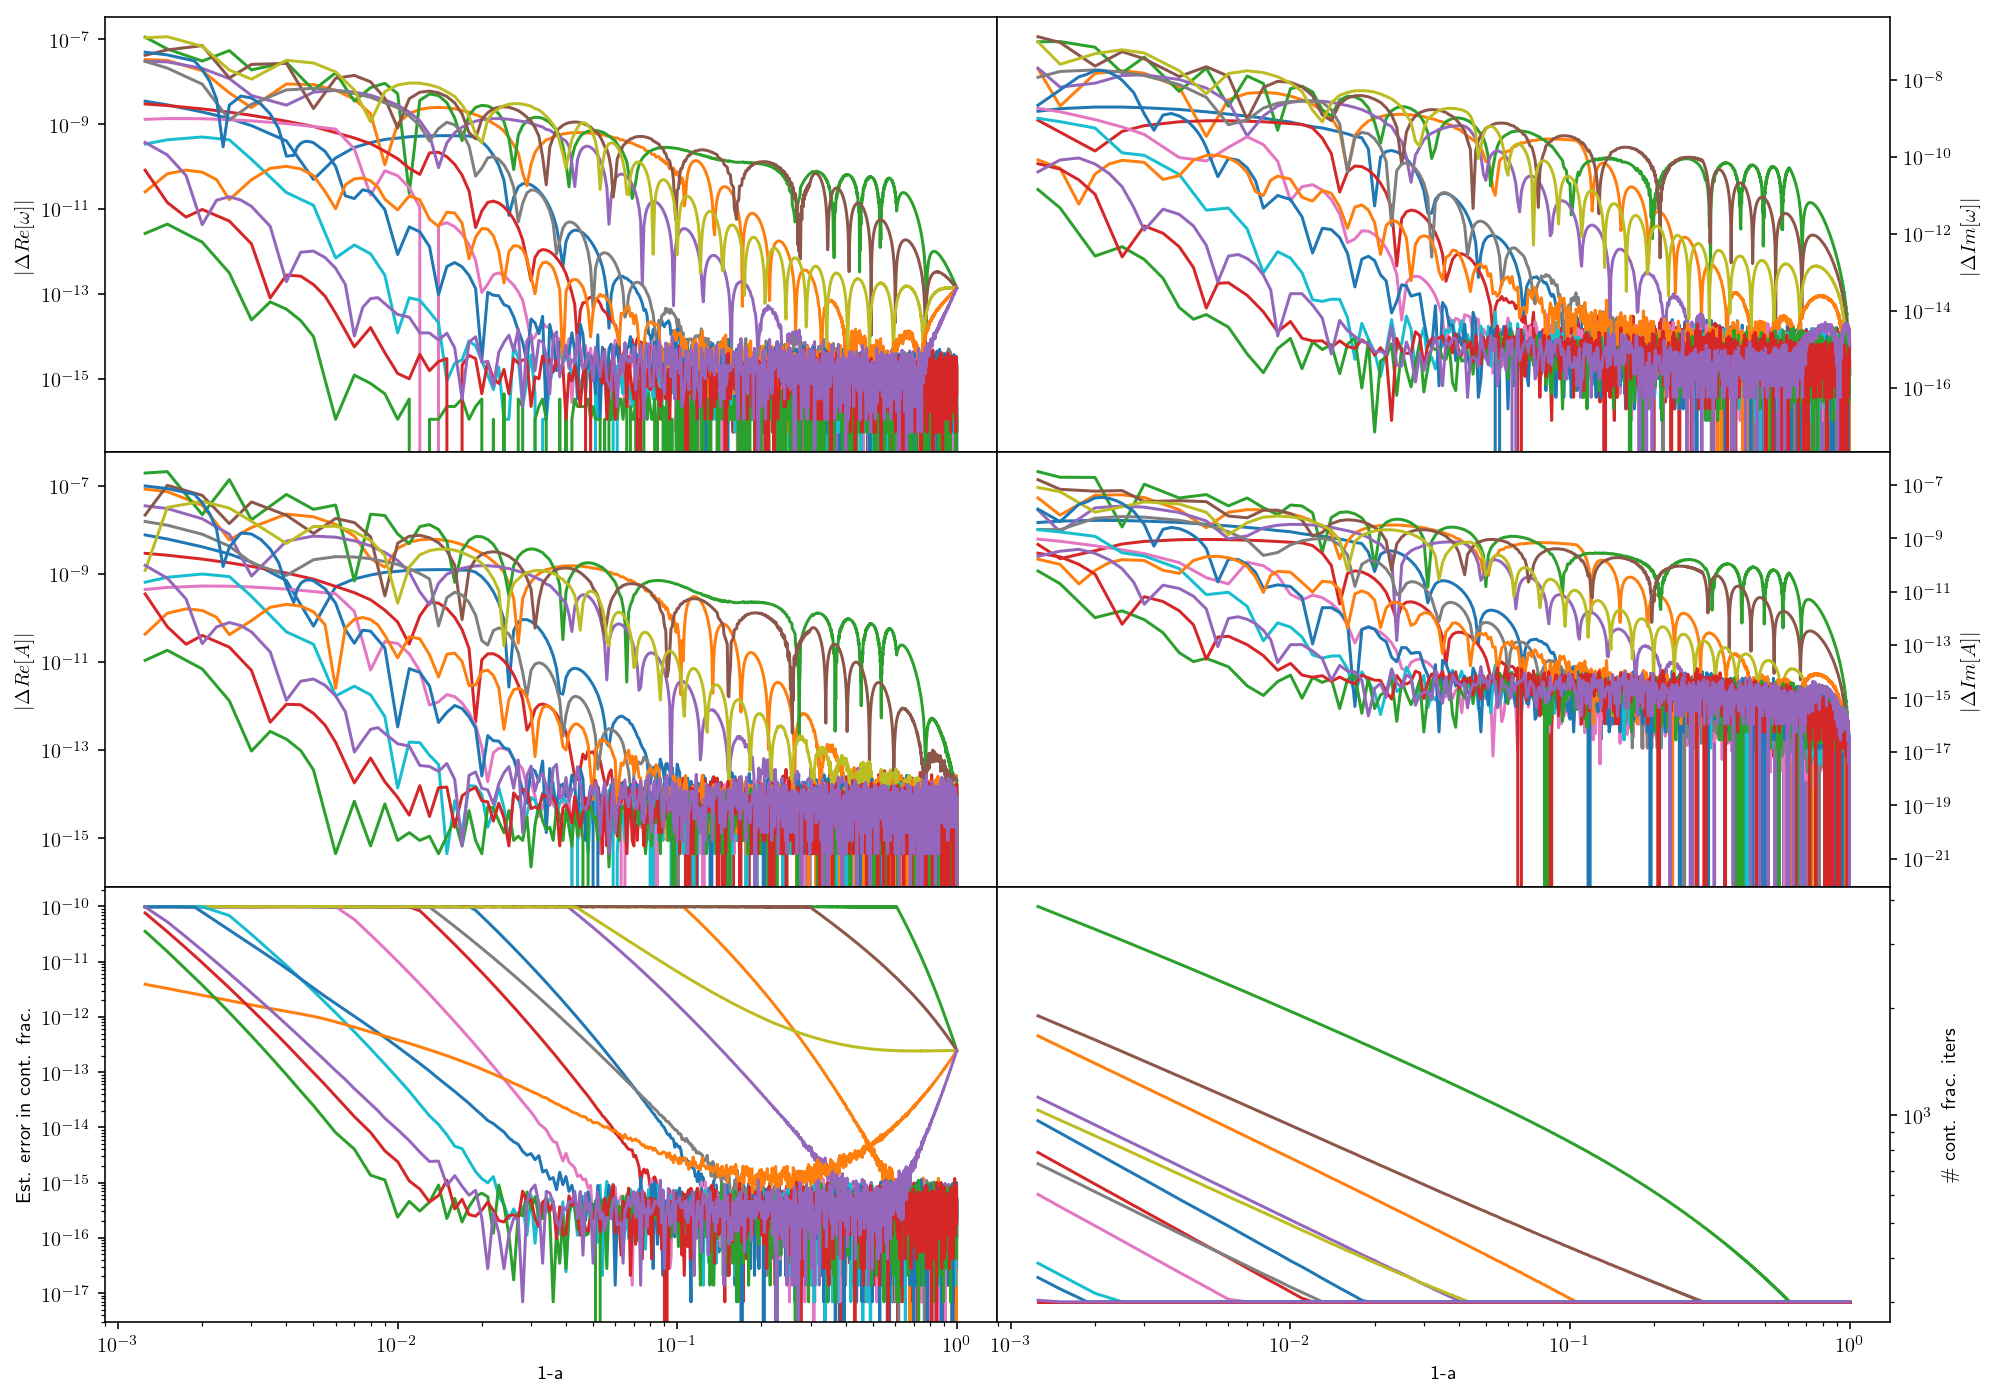

In [12]:
s=-2 # Cook only has s=-2
# Choose which modes to compare here
l=2
ms=np.arange(-l,l+1)
ns=np.arange(0,3)

fig, axes = plt.subplots(3,2, sharex=True, sharey=False, figsize=(16,12))

for m in ms:
    for n in ns:
        qmode = qnm.modes_cache(s=s,l=l,m=m,n=n)
        qmode.solver.set_params(tol=1e-10, Nr_max=10000)
        avals = cook[(l,m,n)]['a']
        
        to_compare = avals < 0.999
        avals = avals[to_compare]

        oms = []
        As  = []
        Clasts = []
        cf_errs = []
        n_fracs = []
        for a in avals:
            om, A, Cs = qmode(a=a, store=False, resolve_if_found=True)
            oms.append(om)
            As.append(A)
            Clasts.append(Cs[-1])
            cf_err, n_frac = qmode.solver.get_cf_err()
            cf_errs.append(cf_err)
            n_fracs.append(n_frac)
        
        delta_oms = cook[(l,m,n)]['omega'][to_compare] - oms
        delta_As  = cook[(l,m,n)]['A'][to_compare] - As
        
        axes[0,0].loglog(1.-avals, np.abs(np.real(delta_oms)))
        axes[0,1].loglog(1.-avals, np.abs(np.imag(delta_oms)))
        axes[1,0].loglog(1.-avals, np.abs(np.real(delta_As)))
        axes[1,1].loglog(1.-avals, np.abs(np.imag(delta_As)))
        axes[2,0].loglog(1.-avals, np.abs(cf_errs))
        axes[2,1].loglog(1.-avals, n_fracs)

for n in np.arange(0,3):
    axes[n,1].yaxis.tick_right()
    axes[n,1].yaxis.set_label_position("right"),

axes[0,0].set_ylabel(r'$|\Delta Re[\omega]|$')
axes[0,1].set_ylabel(r'$|\Delta Im[\omega]|$')
axes[1,0].set_ylabel(r'$|\Delta Re[A]|$')
axes[1,1].set_ylabel(r'$|\Delta Im[A]|$')
axes[2,0].set_ylabel('Est. error in cont. frac.')
axes[2,1].set_ylabel(r'\# cont. frac. iters')

axes[2,0].set_xlabel('1-a')
axes[2,1].set_xlabel('1-a')

fig.subplots_adjust(hspace=0, wspace=0)

plt.savefig("Cook-comparison.png", bbox_inches='tight', dpi=150)

plt.show()